In [1]:
import pandas as pd
import statsmodels as sm
#import tensorflow as tf
#import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def Classification_metrics(y_test, y_pred):
    # Calculate metrics for each class
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f_score = f1_score(y_test, y_pred, average=None)

    print(f"Accuracy: {accuracy}") #exactitud
    print(f"Precision: {precision}") #precisión
    print(f"Recall: {recall}") #recordar...? evocar
    print(f"F-Score: {f_score}") 
    return accuracy, precision, recall, f_score

In [ ]:
#importamos la librería
from sklearn.datasets import load_breast_cancer
#cargamos la función para dividir el dataset
from sklearn.model_selection import train_test_split

#Cargamos los datos
dataset = load_breast_cancer(as_frame=True)
print(dataset.keys())
print(dataset.data.shape, dataset.data.columns.to_list())
print(dataset.target.shape, dataset.target.name)
print(dataset.feature_names)
print(dataset.target_names)

labels = dataset.data.columns.to_list()

def iniciar_dataset(dataset, labels, test_size, seed = 17):
    X = dataset.data[labels] #por facilidad de representación, utilizaremos sólo dos variables
    y = dataset.target  
    #dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y, random_state = seed)
    #comprobamos la forma de las variables
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
(569, 30) ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
(569,) target
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity 

# Test de McNemar.
Empezamos con el test de McNemar, y luego aprovechamos las definiciones para utilizar en 5x2cv t-paired test, ya que sólo necesitaremos cambiar el tamaño del dataset.

# Modelo A

In [5]:
#Clasificador lineal
from sklearn import linear_model #importamos el modelo
def Regresion(X_train, y_train, X_test):
    reg = linear_model.LogisticRegression(solver='liblinear', multi_class='ovr') #utilizamos un clasificador simple, ahora no nos interesa tanto usar un modelo adecuado tanto como evaluar si lo es

    #por lo general al ser un clasificador deberíamos codificar los valores categóricos, 
    #pero en los datos de dataset ya vienen con un valor asociado a cada clase
    reg.fit(X_train, y_train) #adaptamos modelo
    y_pred = reg.predict(X_test) #predecimos test
    return y_pred

In [ ]:
#labels = ["petal width (cm)", "sepal width (cm)"]
test_size = 0.2 #Dividimos nuestro set en 80% train y 20% test.
X_train, X_test, y_train, y_test = iniciar_dataset(dataset, labels, test_size)
y_pred_modeloA = Regresion(X_train, y_train, X_test)
accuracy, precision, recall, f_score = Classification_metrics(y_test, y_pred_modeloA)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_modeloA))


(455, 30) (455,)
(114, 30) (114,)
Accuracy: 0.9736842105263158
Precision: [0.95348837 0.98591549]
Recall: [0.97619048 0.97222222]
F-Score: [0.96470588 0.97902098]
Mean squared error: 0.03


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modelo B

In [ ]:
def Knn_classification(dataset, labels, X_train, y_train):
    X = dataset.data[labels] 
    y = dataset.target  
    #creamos una pipeline que escale nuestros datos, pues knn es sensible a ello
    scaler_PCA = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2))
    ])
    scaler_PCA.fit(X_train, y_train)
    X_train_pca = scaler_PCA.transform(X_train)
    clf = Pipeline(steps=[
        ("knn", KNeighborsClassifier(n_neighbors=11))
    ])
    clf.fit(X_train_pca, y_train)
    return clf, scaler_PCA, X_train_pca

def knn_plot(clf, scaler_PCA, X_train_pca, y_train):
    X_all = dataset.data[labels]
    y_all = dataset.target
    X_all_pca = scaler_PCA.transform(X_all)
    X_test_pca = scaler_PCA.transform(X_test)
    # Creamos figura con dos subplots
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    for ax, weights in zip(axs, ("uniform", "distance")):
        clf.set_params(knn__weights=weights).fit(X_train_pca, y_train)

        disp = DecisionBoundaryDisplay.from_estimator(
            clf,
            X_test_pca,  # importante: aquí pasamos X_test en dimensiones originales
            response_method="predict",
            plot_method="pcolormesh",
            xlabel="PS1",
            ylabel="PS2",
            shading="auto",
            alpha=0.3,
            ax=ax
        )

        scatter = ax.scatter(
            X_all_pca[:, 0], X_all_pca[:, 1], c=y_all, edgecolors="k"#, cmap=disp.cmap
        )

        ax.legend(
            scatter.legend_elements()[0],
            dataset.target_names,
            loc="lower left",
            title="Classes"
        )

        ax.set_title(
            f"Breast Cancer Classification\n(k={clf.named_steps['knn'].n_neighbors}, weights={weights!r})"
        )

    plt.tight_layout()
    plt.show()
    return None

In [9]:
from statsmodels.stats.contingency_tables import mcnemar

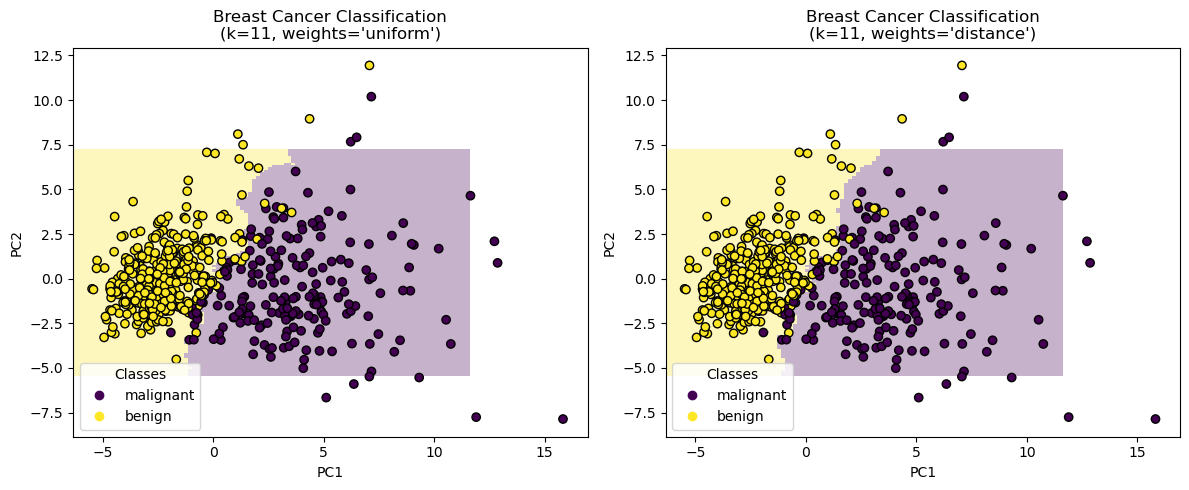

In [10]:
clf, scaler_PCA, X_train_pca = Knn_classification(dataset, labels, X_train, y_train)
knn_plot(clf, scaler_PCA, X_train_pca, y_train)
y_pred_ModeloB = clf.predict(scaler_PCA.transform(X_test))

In [11]:
accuracy, precision, recall, f_score = Classification_metrics(y_test, y_pred_ModeloB)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ModeloB))

Accuracy: 0.9298245614035088
Precision: [0.925      0.93243243]
Recall: [0.88095238 0.95833333]
F-Score: [0.90243902 0.94520548]
Mean squared error: 0.07


# Aplicación del test

In [12]:
exito_fracaso_Modelo_A = y_pred_modeloA == y_test
exito_fracaso_Modelo_B = y_pred_ModeloB == y_test

In [28]:
len(exito_fracaso_Modelo_A), len(exito_fracaso_Modelo_B)

(114, 114)

In [54]:
n00 = sum((exito_fracaso_Modelo_A == 1) * (exito_fracaso_Modelo_B == 1)) #ambos correctos
n01 = sum((exito_fracaso_Modelo_A == 1) * abs((exito_fracaso_Modelo_B == 1)-1)) #A bien predicho, B mal
n10 = sum(abs((exito_fracaso_Modelo_A == 1)-1) * (exito_fracaso_Modelo_B == 1)) #B bien predicho, A mal
n11 = sum((exito_fracaso_Modelo_A == 0) * (exito_fracaso_Modelo_B == 0)) #ambos incorrectos

In [55]:
n01

6

In [ ]:
tablaContingencia = [[n00, n10], [n01, n11]]
tablaContingencia_df = pd.DataFrame(
    tablaContingencia,
    #index=["ambos correctos", "A bien predicho, B mal"],
    #columns=["B bien predicho, A mal", "ambos incorrectos"]
)
assert tablaContingencia_df.sum().sum() == len(y_test) #comprobación de que el numero de elementos de la tabla de contigencia es correcto
print(tablaContingencia_df)

     0  1
0  105  1
1    6  2


In [106]:
# Create a dataset 
data = tablaContingencia
print(data)
# McNemar's Test with the continuity correction 
print(mcnemar(data, exact=False, correction=False)) 

[[105, 1], [6, 2]]
pvalue      0.05878172135535891
statistic   3.5714285714285716


Por tanto rechazamos la hipótesis nula y a priori podemos decir que efectivamente no son iguales. Si bien, 0.0588 podría no ser un p-valor tan grande e indicar que sigue siendo una muestra pequeña.

# 5x2cv t-paired test

In [ ]:
test_size = 0.5 #Dividimos nuestro set en dos.

(284, 30) (284,)
(285, 30) (285,)


In [ ]:
seeds = [21, 13, 89, 14, 22] #defino diferentes seed, por tener reproducibilidad pero necesitamos un splitting diferente en cada iteración.
count = 0
names = ['Modelo A S1 acc', 'Modelo A S2 acc', 'Modelo B S1 acc', 'Modelo B S2 acc', 'Diferencia acc A', 'Diferencia acc B', 'media', 'varianza']
lista = []
for i in range(len(seeds)):
    sublista = []
    count = count + 1
    #splitting
    S1_X, S2_X, S1_y, S2_y = iniciar_dataset(dataset, labels, test_size, i) #el número de ejemplos es impar, por lo que no 

    #Modelo A
    ##S1 training, S2_test
    y_S1_A = Regresion(S1_X, S1_y, S2_X)
    acc_S1_A = accuracy_score(S2_y, y_S1_A)
    sublista.append(acc_S1_A)
    ##S2 training, S1_test
    y_S2_A = Regresion(S2_X, S2_y, S1_X)
    acc_S2_A = accuracy_score(S1_y, y_S2_A)
    sublista.append(acc_S2_A)

    #Modelo B
    ##S1 training, S2_test
    clf, scaler_PCA, S1_X_pca = Knn_classification(dataset, labels, S1_X, S1_y)
    y_S1_B = clf.predict(scaler_PCA.transform(S2_X))
    acc_S1_B = accuracy_score(S2_y, y_S1_B)
    sublista.append(acc_S1_B)

    ##S2 training, S1_test
    clf, scaler_PCA, S2_X_pca = Knn_classification(dataset, labels, S2_X, S2_y)
    y_S2_B = clf.predict(scaler_PCA.transform(S1_X))
    acc_S2_B = accuracy_score(S1_y, y_S2_B)
    sublista.append(acc_S2_B)

    #diferencias
    difS1 = acc_S1_A - acc_S1_B
    difS2= acc_S1_A - acc_S2_B
    sublista.append(difS1)
    sublista.append(difS2)

    difMedia = (difS1 + difS2)/2
    varMedia = (difS1 - difMedia)**2 + (difS2 - difMedia)**2
    sublista.append(difMedia)
    sublista.append(varMedia)

    lista.append(sublista)

(284, 30) (284,)
(285, 30) (285,)
(284, 30) (284,)
(285, 30) (285,)
(284, 30) (284,)
(285, 30) (285,)
(284, 30) (284,)
(285, 30) (285,)
(284, 30) (284,)
(285, 30) (285,)


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ruthy/miniconda3/envs/tf-gpu/lib/python3

In [89]:
tabla = pd.DataFrame(
    lista,
    columns=names,
    index=['Iter ' + str(i) for i in range(len(seeds))]
)
tabla = tabla.transpose()
tabla

,Iter 0,Iter 1,Iter 2,Iter 3,Iter 4
Modelo A S1 acc,0.940351,0.961404,0.950877,0.957895,0.954386
Modelo A S2 acc,0.954225,0.940141,0.954225,0.940141,0.943662
Modelo B S1 acc,0.940351,0.926316,0.936842,0.943860,0.936842
Modelo B S2 acc,0.950704,0.947183,0.929577,0.933099,0.950704
Diferencia acc A,0.000000,0.035088,0.014035,0.014035,0.017544
Diferencia acc B,-0.010353,0.014220,0.021300,0.024796,0.003682
media,-0.005177,0.024654,0.017667,0.019416,0.010613
varianza,0.000054,0.000218,0.000026,0.000058,0.000096


In [116]:
firstValue = tabla.loc['Diferencia acc B','Iter 0']
sumVar = tabla.loc['varianza'].sum()
denominador = np.sqrt((1/len(seeds))*sumVar)
estadistico = firstValue/denominador

In [117]:
firstValue

np.float64(-0.010353348159130138)

In [118]:
estadistico

np.float64(-1.0893011253563116)

In [102]:
import scipy.stats

In [105]:
scipy.stats.t.sf(abs(estadistico), len(seeds))

np.float64(0.1628573443537449)

En este caso el p-valor es más grande, por lo que parece quedar más afianzada el rechazo de la hipótesis nula. Por tanto, se puede concluir con bastante confianza que el modelo A es más exacto que el modelo B.